In [13]:
import igraph as ig
import numpy as np
import os
import pandas as pd
import networkx as nx
import nx_cugraph as nxcg
import powerlaw
import random
from time import time
import matplotlib.pyplot as plt
from auxiliar_bb import noise_corrected, disparity
from auxiliar_projections_large import apply_projection

In [11]:
FILENAME = "TOY-GRAPH.graphml"
FILENAME = "binet-AMZ-Rw.graphml"

In [12]:
###### ****** Read BI GRAPH ****** ######
g = ig.read(FILENAME)
print(g.summary())
print()

user_nodes = g.vs.select(type=0)
res_nodes = g.vs.select(type=1)

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()
print("|U|=",len(user_nodes), " \t|R|=",len(res_nodes), " \t|U|+|R|=",
      len(user_nodes)+len(res_nodes), "=", g.vcount())
print()
###### ****** END ****** ######

IGRAPH U-WT 17079 32769 -- 
+ attr: freq (v), id (v), type (v), weight (e)

The graph IS bipartite
|U|= 9561  	|R|= 7518  	|U|+|R|= 17079 = 17079



In [6]:
def bipartite_cc_uu_prime(graph, u_id, u_prime_id):
    """
    Calculates the Jaccard index based clustering coefficient for a pair of vertices
    u and u' from the same set of nodes in a bipartite graph.

    Args:
        graph: An igraph Graph object. Must be bipartite with a 'type' vertex attribute.
        u_id: The ID of the first vertex.
        u_prime_id: The ID of the second vertex.

    Returns:
        The Jaccard index (cc_u_u_prime) or 0 if union of neighbors is empty.
    """
    if not graph.is_bipartite():
        raise ValueError("Graph must be bipartite.")

    # Get neighbors of u and u'
    neighbors_u = set(graph.neighbors(u_id))
    neighbors_u_prime = set(graph.neighbors(u_prime_id))

    # Calculate intersection and union
    intersection = len(neighbors_u.intersection(neighbors_u_prime))
    union = len(neighbors_u.union(neighbors_u_prime))

    if union == 0:
        return 0.0
    return intersection / union
 
def local_bipartite_clustering_coefficient(graph, u_id, U_type_value=False):
    """
    Calculates the local clustering coefficient for a vertex u in a bipartite graph.
    The formula uses neighbors of neighbors (N(N(u))) that are of the same type as u.

    Args:
        graph: An igraph Graph object. Must be bipartite with a 'type' vertex attribute
               (e.g., True/False or 0/1 for the two partitions).
        u_id: The ID of the vertex for which to calculate the local clustering coefficient.
        U_type_value: The boolean value (True/False) that indicates the partition
                      to which node u belongs. All nodes in U should have this type.

    Returns:
        The local clustering coefficient for vertex u, or 0 if N(N(u)) is empty.
    """
    if not graph.is_bipartite():
        raise ValueError("Graph must be bipartite.")
    if "type" not in graph.vs.attributes():
        raise ValueError("Bipartite graph must have a 'type' vertex attribute.")

    # Ensure u_id is of the specified U_type_value
    if graph.vs[u_id]["type"] != U_type_value:
        raise ValueError(f"Vertex {u_id} does not belong to the specified partition U.")

    # Get neighbors of u
    neighbors_u = graph.neighbors(u_id)
    
    # Get neighbors of neighbors of u, filtering for nodes of the same type as u
    # These are the u' nodes in N(N(u)) that are in the same partition U
    nn_u = set()
    for v_neighbor_id in neighbors_u:
        for nn_id in graph.neighbors(v_neighbor_id):
            if graph.vs[nn_id]["type"] == U_type_value and nn_id != u_id: # Exclude u itself
                nn_u.add(nn_id)

    if not nn_u:
        return 0.0

    sum_cc_uu_prime = 0.0
    for u_prime_id in nn_u:
        sum_cc_uu_prime += bipartite_cc_uu_prime(graph, u_id, u_prime_id)

    return sum_cc_uu_prime / len(nn_u)

def average_local_bipartite_clustering_coefficient(graph, U_type_value=False):
    """
    Calculates the average local clustering coefficient for a set of nodes U
    in a bipartite graph.

    Args:
        graph: An igraph Graph object. Must be bipartite with a 'type' vertex attribute.
        U_type_value: The boolean value (True/False) that indicates the partition
                      for which to calculate the average clustering coefficient.

    Returns:
        The average local clustering coefficient for the set U.
    """
    if not graph.is_bipartite():
        raise ValueError("Graph must be bipartite.")
    if "type" not in graph.vs.attributes():
        raise ValueError("Bipartite graph must have a 'type' vertex attribute.")

    # Get all vertices in set U
    U_vertices_ids = [v.index for v in graph.vs if v["type"] == U_type_value]

    if not U_vertices_ids:
        return 0.0

    sum_cc_u = 0.0
    for u_id in U_vertices_ids:
        sum_cc_u += local_bipartite_clustering_coefficient(graph, u_id, U_type_value)

    return sum_cc_u / len(U_vertices_ids)

def compute_power_law_bipartite(gb, type_n=1):
    """Calcula el alpha del bipartita"""
    fit = powerlaw.Fit(gb.degree(gb.vs.select(type=type_n)), discrete=True, verbose=False)
    return fit.alpha

def compute_power_law(g):
    """Calcula el alpha del proyectado"""
    fit = powerlaw.Fit(g.degree(), discrete=True, verbose=False)
    return fit.alpha

In [ ]:
def compute_avg_path_length(g, k):
    G = g.to_networkx()
    nxG = nxcg.from_networkx(G)
    all_nodes = list(G.nodes())
    sample_nodes = random.sample(all_nodes, k)
    total_distances = 0
    reachable_pairs = 0
    for i, src_node in enumerate(sample_nodes):
        sssp_df = nxcg.shortest_path_length(nxG, source=src_node)
        total_distances += sum(sssp_df.values())
        reachable_pairs += len(sssp_df.values())

    apl_approx = float(total_distances) / reachable_pairs
    return apl_approx


def compute_bip_metrics(gb, typen):
    """Calcula x1,x2,x3,x8,x9,γ_Ub del grafo bipartito."""
    x1 = len(gb.vs.select(type=0))
    x2 = len(gb.vs.select(type=1))
    x3 = gb.ecount()
    #x8 = average_local_bipartite_clustering_coefficient(gb, U_type_value=typen)    
    x8 = 1
    x9 = compute_avg_path_length(gb, 100)
    x11 = compute_power_law_bipartite(gb, typen)
    return dict(x1=x1, x2=x2, x3=x3, x8=x8, x9=x9, x11=x11)

def compute_proj_metrics(gu):
    """Calcula x4,x5,x6,x7,x10,γ_U de la proyección."""
    x4 = gu.vcount()
    x5 = gu.ecount()
    x6 = len(gu.clusters(mode='weak'))
    x7 = gu.transitivity_undirected(mode="zero")
    x10 = compute_avg_path_length(gu, 100)
    #try:
    #    x10 = gu.average_path_length(directed=False)
    #except:
    #    x10 = np.inf
    x12 = compute_power_law(gu)
    return dict(x4=x4, x5=x5, x6=x6, x7=x7, x10=x10, x12=x12)

def evaluate_solution(bip, proj, typen):
    """Dado bip y proj metrics, arma x, f, g."""
    # unimos diccionarios
    x = {
        **bip,
        **proj
    }
    # objetivos
    f = np.array([
        abs(x["x1"] - x["x4"]) if typen==0 else abs(x["x2"] - x["x4"]),
        (2*x["x5"]) / (x["x4"]*(x["x4"]-1)) if x["x4"]>1 else np.inf,
        x["x6"],
        1 - x["x7"],
        abs(x["x11"] - x["x12"]),
        abs(x["x9"] - x["x10"]),
    ])
    # restricciones g_i(x)<=0
    g = np.array([
        f[1] - x["x3"]/(x["x1"]*x["x2"]) if x["x1"]*x["x2"]>0 else np.inf,
    ])
    return dict(metrics=x, f=f, g=g, graph=proj)
    #return dict(metrics=x, f=f, graph=proj)

def is_feasible(sol):
    #return np.all(sol["g"] <= 0)
    if np.all(sol["g"] <= 0):
        return 1

def pareto_front(sols):
    front = []
    for i, si in enumerate(sols):
        if any(np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"])
               for j, sj in enumerate(sols) if i!=j):
            continue
        front.append(si)
    return front

def crowding_distance(front):
    N, k = len(front), front[0]["f"].size
    F = np.array([s["f"] for s in front])
    dist = np.zeros(N)
    for m in range(k):
        idx = np.argsort(F[:,m])
        f_min, f_max = F[idx[0],m], F[idx[-1],m]
        dist[idx[0]] = dist[idx[-1]] = np.inf
        if f_max == f_min: continue
        for i in range(1, N-1):
            dist[idx[i]] += (F[idx[i+1],m] - F[idx[i-1],m]) / (f_max - f_min)
    return dist

def pareto_rank_all(solutions):
    """
    Clasifica todas las soluciones en frentes de Pareto.
    Devuelve una lista de listas: cada sublista contiene un frente.
    """
    remaining = solutions.copy()
    fronts = []
    
    while remaining:
        current_front = []
        for i, si in enumerate(remaining):
            dominated = False
            for j, sj in enumerate(remaining):
                if i == j:
                    continue
                if np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"]):
                    dominated = True
                    break
            if not dominated:
                current_front.append(si)
        
        fronts.append(current_front)
        remaining = [s for s in remaining if all(s is not r for r in current_front)]
    
    return fronts



In [33]:
# —————————— Flujo principal ——————————
tnodes = 0

# 1) Leer el único grafo bipartito
gb = ig.Graph.Read_GraphML("binet-AMZ-Rw.graphml")
bip_metrics = compute_bip_metrics(gb, tnodes)
bip_metrics

/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


{'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 1,
 'x9': 5.53053323717653,
 'x11': 3.8553228787812426}

In [65]:
# 2) Escanear carpeta de proyecciones
if tnodes == 0:
    proj_dir = "grafos"    
else:
    proj_dir = "grafos2"
    
proj_files = [f for f in os.listdir(proj_dir)
              if f.endswith(".graphml") and f!="bipartito.graphml"]


# 3) Calcular soluciones
solutions = []
conta_neg = 0
to_df = []
names_df = []
for fname in proj_files:
    gu = ig.Graph.Read_GraphML(os.path.join(proj_dir, fname))
    proj_metrics = compute_proj_metrics(gu)
    sol = evaluate_solution(bip_metrics, proj_metrics, tnodes)
    to_df.append(sol["f"])
    names_df.append(fname[:-8])
    sol["filename"] = fname  # <- Añadimos esta línea
    solutions.append(sol)
    #if is_feasible(sol):
    #    solutions.append(sol)
    
a = pd.DataFrame(to_df)
b = pd.DataFrame(names_df)
a.columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
b.columns = ["name"]
final_DF = pd.concat([a, b], axis=1)
print("Soluciones factibles:", len(solutions))

/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


Soluciones factibles: 56


In [66]:
final_DF

,f1,f2,f3,f4,f5,f6,name
0,2043.0,0.001947,459.0,0.910915,1.041712,2.315536,amz_bot_resall_DF_alpha2
1,2043.0,0.002291,275.0,0.847471,1.177166,2.168949,amz_bot_weights_NC_alpha05
2,2043.0,0.000545,1751.0,0.703548,0.668581,0.699438,amz_bot_master_w_DF_alpha2
3,2043.0,0.001946,459.0,0.910959,0.994492,2.307023,amz_bot_resall_DF_alpha15
4,1.0,0.027429,274.0,0.365256,1.632665,2.814607,amz_bot_resall_w_NC_alpha2
5,2043.0,0.002558,275.0,0.894612,1.328815,2.670312,amz_bot_resall_NC_alpha1
6,2043.0,0.002558,275.0,0.894612,1.328815,2.583841,amz_bot_master_NC_alpha2
7,1.0,0.003546,379.0,0.728672,0.560178,1.980409,amz_bot_resall_w_DF_alpha2
8,2043.0,0.002493,275.0,0.901779,1.130790,2.350068,amz_bot_hyper_w_NC_alpha15
9,2043.0,0.000257,4498.0,0.900378,1.451695,1.531662,amz_bot_hyper_w_DF_alpha15


<AxesSubplot:>

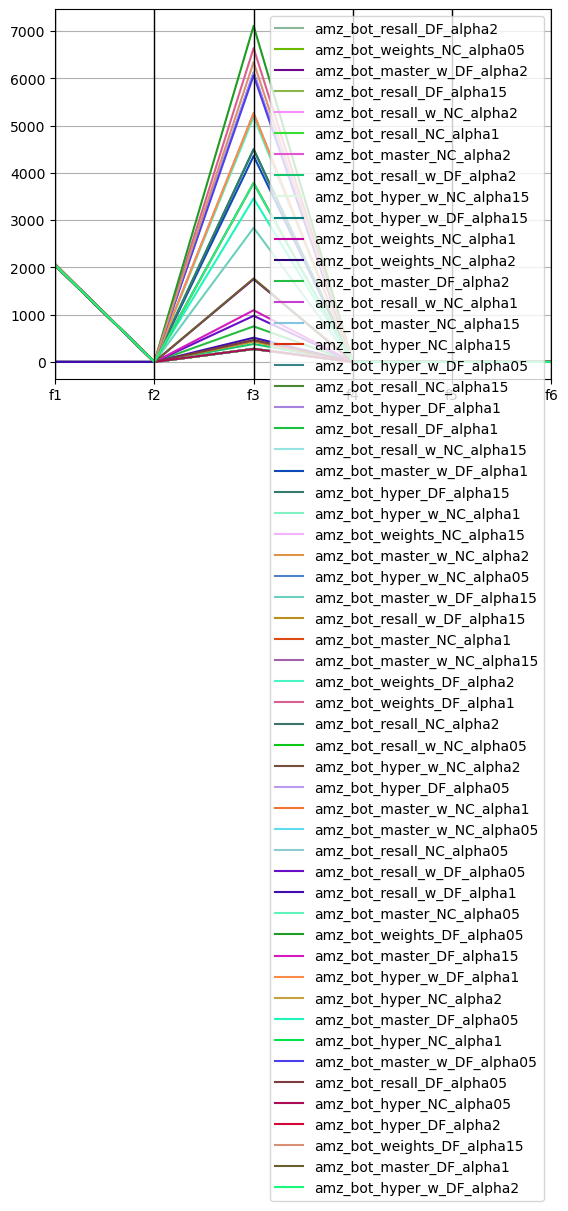

In [71]:
pd.plotting.parallel_coordinates(final_DF, 'name')  

In [67]:
all_fronts = pareto_rank_all(solutions)

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol in front:
        print(f" - {sol['filename']} — f = {sol['f']}")



Frente 1 (23 soluciones):
 - amz_bot_resall_DF_alpha2.graphml — f = [2.04300000e+03 1.94738163e-03 4.59000000e+02 9.10915156e-01
 1.04171150e+00 2.31553598e+00]
 - amz_bot_master_w_DF_alpha2.graphml — f = [2.04300000e+03 5.44761483e-04 1.75100000e+03 7.03548222e-01
 6.68581405e-01 6.99438310e-01]
 - amz_bot_resall_DF_alpha15.graphml — f = [2.04300000e+03 1.94575368e-03 4.59000000e+02 9.10958914e-01
 9.94492082e-01 2.30702304e+00]
 - amz_bot_resall_w_DF_alpha2.graphml — f = [1.00000000e+00 3.54604590e-03 3.79000000e+02 7.28671533e-01
 5.60177797e-01 1.98040924e+00]
 - amz_bot_master_DF_alpha2.graphml — f = [2.04300000e+03 9.07794244e-04 7.52000000e+02 8.21790681e-01
 6.30769818e-01 7.37674919e-01]
 - amz_bot_hyper_w_DF_alpha05.graphml — f = [2.04300000e+03 9.09174462e-05 6.12200000e+03 8.46907243e-01
 1.59781753e+00 9.58559255e-01]
 - amz_bot_hyper_DF_alpha1.graphml — f = [2.04300000e+03 1.67608029e-04 5.25900000e+03 8.81891247e-01
 1.51972106e+00 8.96157925e-01]
 - amz_bot_resall_DF_a

In [68]:

cd = crowding_distance(all_fronts[0])
pareto_sorted = [s for _, s in sorted(zip(-cd, all_fronts[0]), key=lambda x: x[0])]
print("Crowding", len(pareto_sorted))
print(pareto_sorted)

Crowding 23
[{'metrics': {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 1, 'x9': 5.53053323717653, 'x11': 3.8553228787812426, 'x4': 7518, 'x5': 54980, 'x6': 459, 'x7': 0.08904108558478074, 'x10': 3.223510198758721, 'x12': 2.8608307970603475}, 'f': array([2.04300000e+03, 1.94575368e-03, 4.59000000e+02, 9.10958914e-01,
       9.94492082e-01, 2.30702304e+00]), 'graph': {'x4': 7518, 'x5': 54980, 'x6': 459, 'x7': 0.08904108558478074, 'x10': 3.223510198758721, 'x12': 2.8608307970603475}, 'filename': 'amz_bot_resall_DF_alpha15.graphml'}, {'metrics': {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 1, 'x9': 5.53053323717653, 'x11': 3.8553228787812426, 'x4': 9560, 'x5': 129568, 'x6': 430, 'x7': 0.25879680917813874, 'x10': 3.847080049045367, 'x12': 3.732284174710398}, 'f': array([1.00000000e+00, 2.83568115e-03, 4.30000000e+02, 7.41203191e-01,
       1.23038704e-01, 1.68345319e+00]), 'graph': {'x4': 9560, 'x5': 129568, 'x6': 430, 'x7': 0.25879680917813874, 'x10': 3.847080049045367, 'x12': 3.7322841747103

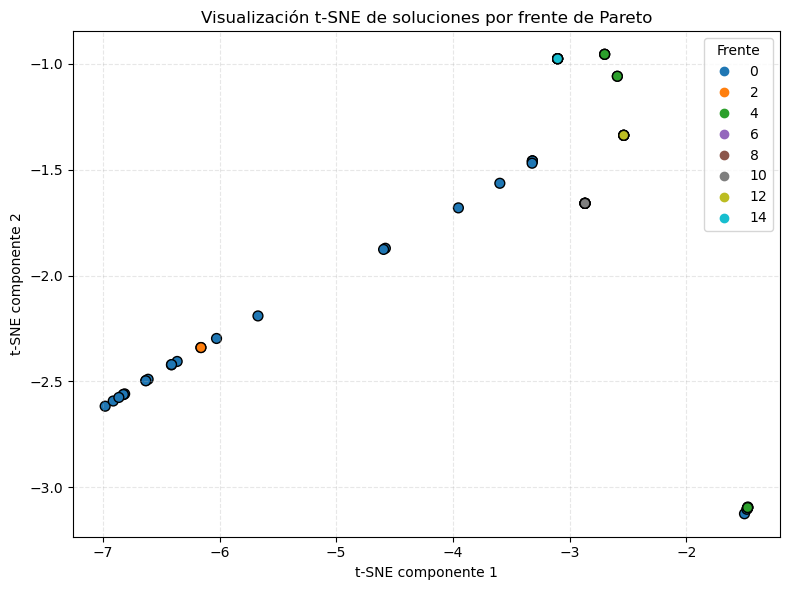

In [69]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que ya tienes: all_fronts = pareto_rank_all(solutions)

# Preparar datos
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)  # índice de frente

points = np.array(points)
labels = np.array(labels)

# Aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedding = tsne.fit_transform(points)

# Graficar
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=labels, cmap="tab10", s=50, edgecolors='k')

plt.title("Visualización t-SNE de soluciones por frente de Pareto")
plt.xlabel("t-SNE componente 1")
plt.ylabel("t-SNE componente 2")
plt.grid(True, linestyle="--", alpha=0.3)
legend = plt.legend(*scatter.legend_elements(), title="Frente", loc="upper right")
plt.tight_layout()
plt.show()


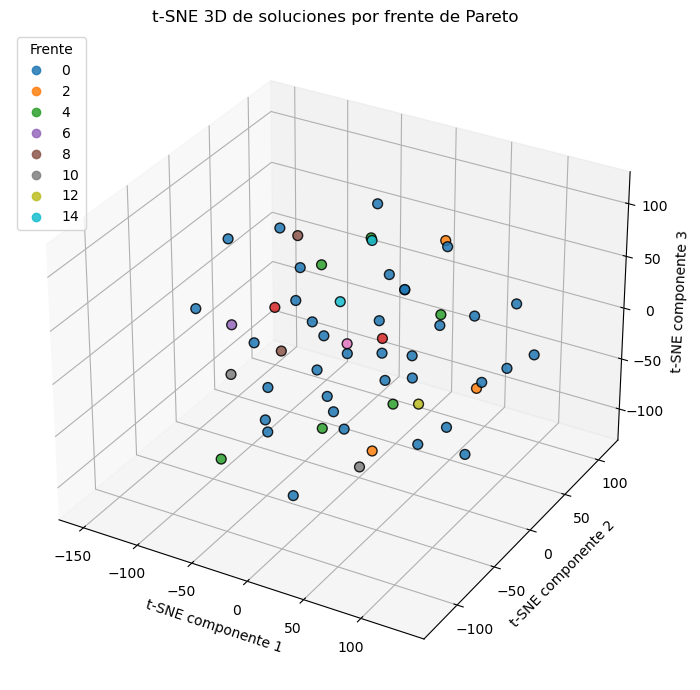

In [58]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necesario para proyecciones 3D
import numpy as np

# Preparar puntos y etiquetas
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)

points = np.array(points)
labels = np.array(labels)

# Aplicar t-SNE en 3D
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
embedding = tsne.fit_transform(points)

# Crear gráfico 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2],
                     c=labels, cmap="tab10", s=50, edgecolors='k', alpha=0.85)

ax.set_title("t-SNE 3D de soluciones por frente de Pareto")
ax.set_xlabel("t-SNE componente 1")
ax.set_ylabel("t-SNE componente 2")
ax.set_zlabel("t-SNE componente 3")
legend = plt.legend(*scatter.legend_elements(), title="Frente", loc="upper left")
plt.tight_layout()
plt.show()


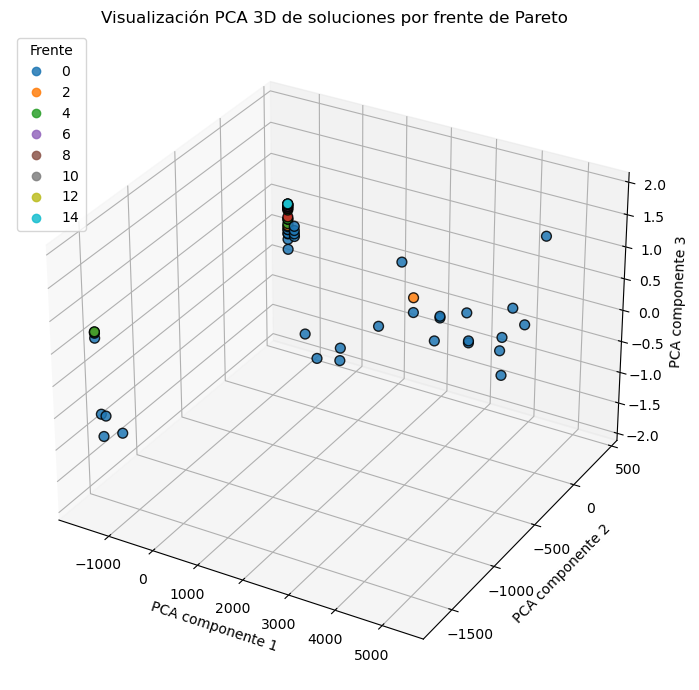

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Preparar puntos y etiquetas
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)

points = np.array(points)
labels = np.array(labels)

# Aplicar PCA en 3 componentes
pca = PCA(n_components=3)
embedding = pca.fit_transform(points)

# Graficar en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2],
                     c=labels, cmap="tab10", s=50, edgecolors='k', alpha=0.85)

ax.set_title("Visualización PCA 3D de soluciones por frente de Pareto")
ax.set_xlabel("PCA componente 1")
ax.set_ylabel("PCA componente 2")
ax.set_zlabel("PCA componente 3")
legend = plt.legend(*scatter.legend_elements(), title="Frente", loc="upper left")
plt.tight_layout()
plt.show()


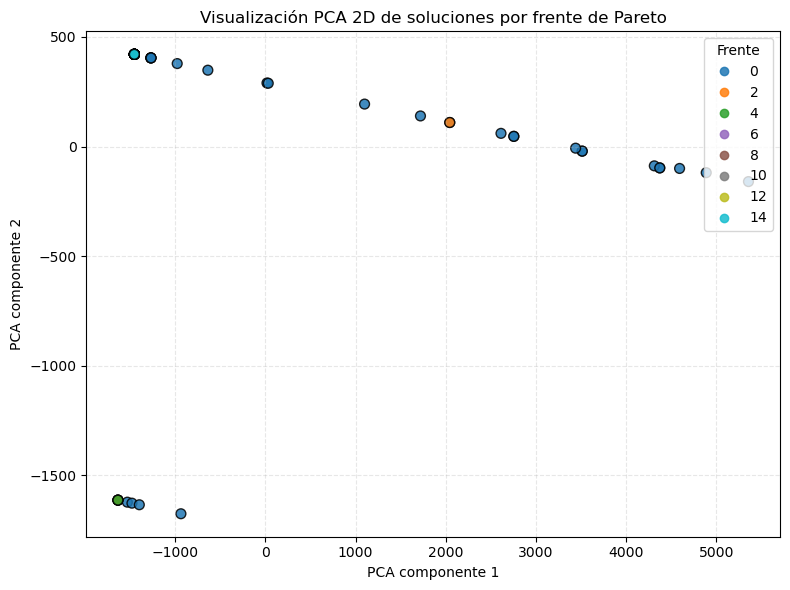

In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que ya tienes: all_fronts = pareto_rank_all(solutions)

# Preparamos los datos
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)

points = np.array(points)
labels = np.array(labels)

# PCA en 2 componentes
pca = PCA(n_components=2)
embedding = pca.fit_transform(points)

# Graficar
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=labels, cmap="tab10", s=50, edgecolors='k', alpha=0.85)

plt.title("Visualización PCA 2D de soluciones por frente de Pareto")
plt.xlabel("PCA componente 1")
plt.ylabel("PCA componente 2")
plt.grid(True, linestyle="--", alpha=0.3)
legend = plt.legend(*scatter.legend_elements(), title="Frente", loc="upper right")
plt.tight_layout()
plt.show()


In [38]:
to_save = pd.DataFrame(solutions)

In [39]:
to_save.to_csv("datos_proj_2.csv")

In [49]:
# 4) Extraer Pareto y ordenar por crowding distance
pareto = pareto_front(solutions)
print("Solucion pareto", len(pareto))
print(pareto)

Solucion pareto 55
[{'metrics': {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 0.25, 'x9': 5.635052745891971, 'x11': 2.154744528081951, 'x4': 9560, 'x5': 101111, 'x6': 512, 'x7': 0.25413843317540263, 'x10': 4.114399691152949, 'x12': 5.936446864253645}, 'f': array([1.00000000e+00, 2.21288094e-03, 5.12000000e+02, 7.45861567e-01,
       3.78170234e+00, 1.52065305e+00]), 'g': array([0.00175699]), 'graph': {'x4': 9560, 'x5': 101111, 'x6': 512, 'x7': 0.25413843317540263, 'x10': 4.114399691152949, 'x12': 5.936446864253645}, 'filename': 'amz_top_resall_DF_alpha1.graphml'}, {'metrics': {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 0.25, 'x9': 5.635052745891971, 'x11': 2.154744528081951, 'x4': 9557, 'x5': 54451, 'x6': 3564, 'x7': 0.5062283409928529, 'x10': 5.203962813816858, 'x12': 2.7593817939700473}, 'f': array([4.00000000e+00, 1.19244437e-03, 3.56400000e+03, 4.93771659e-01,
       6.04637266e-01, 4.31089932e-01]), 'g': array([0.00073656]), 'graph': {'x4': 9557, 'x5': 54451, 'x6': 3564, 'x7': 0.506

In [44]:

cd = crowding_distance(pareto)
pareto_sorted = [s for _, s in sorted(zip(-cd, pareto), key=lambda x: x[0])]
print("Crowding", len(pareto_sorted))
print(pareto_sorted)

Crowding 55
[{'metrics': {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 0.25, 'x9': 5.635052745891971, 'x11': 2.154744528081951, 'x4': 9560, 'x5': 101111, 'x6': 512, 'x7': 0.25413843317540263, 'x10': 4.114399691152949, 'x12': 5.936446864253645}, 'f': array([1.00000000e+00, 2.21288094e-03, 5.12000000e+02, 7.45861567e-01,
       3.78170234e+00, 1.52065305e+00]), 'g': array([0.00175699]), 'graph': {'x4': 9560, 'x5': 101111, 'x6': 512, 'x7': 0.25413843317540263, 'x10': 4.114399691152949, 'x12': 5.936446864253645}, 'filename': 'amz_top_resall_DF_alpha1.graphml'}, {'metrics': {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 0.25, 'x9': 5.635052745891971, 'x11': 2.154744528081951, 'x4': 9514, 'x5': 1343, 'x6': 8642, 'x7': 0.7527302143723877, 'x10': 5.6890415306492566, 'x12': 2.330060195992617}, 'f': array([4.70000000e+01, 2.96773668e-05, 8.64200000e+03, 2.47269786e-01,
       1.75315668e-01, 5.39887848e-02]), 'g': array([-0.00042621]), 'graph': {'x4': 9514, 'x5': 1343, 'x6': 8642, 'x7': 0.75273021437

In [45]:
# 5) Salida: lista de grafos óptimos (proyecciones)
optimal_graphs = [s["graph"] for s in pareto_sorted]
print("Crowding", len(cd))


Crowding 55


In [46]:
# Ejemplo: imprimir nombres de archivo en orden óptimo
print("Grafos óptimos ordenados por diversidad (crowding distance):")
for i, sol in enumerate(pareto_sorted, 1):
    print(f"{i:02d}. {sol['filename']} — f = {sol['f']}")

Grafos óptimos ordenados por diversidad (crowding distance):
01. amz_top_resall_DF_alpha1.graphml — f = [1.00000000e+00 2.21288094e-03 5.12000000e+02 7.45861567e-01
 3.78170234e+00 1.52065305e+00]
02. amz_top_master_w_DF_alpha05.graphml — f = [4.70000000e+01 2.96773668e-05 8.64200000e+03 2.47269786e-01
 1.75315668e-01 5.39887848e-02]
03. amz_top_weights_NC_alpha1.graphml — f = [1.00000000e+00 1.82019749e-02 2.74000000e+02 4.14068101e-01
 4.25495009e+00 2.84587259e+00]
04. amz_top_hyper_NC_alpha05.graphml — f = [1.00000000e+00 2.74287939e-02 2.74000000e+02 3.65256396e-01
 3.33324323e+00 2.93047484e+00]
05. amz_top_resall_w_DF_alpha2.graphml — f = [2.04300000e+03 5.74949331e-04 1.11600000e+03 9.69589613e-01
 3.52845554e-01 4.74054548e-01]
06. amz_top_master_NC_alpha1.graphml — f = [1.00000000e+00 2.74287939e-02 2.74000000e+02 3.65256396e-01
 3.33324323e+00 2.93047484e+00]
07. amz_top_master_w_NC_alpha15.graphml — f = [1.00000000e+00 2.74287939e-02 2.74000000e+02 3.65256396e-01
 3.3332432

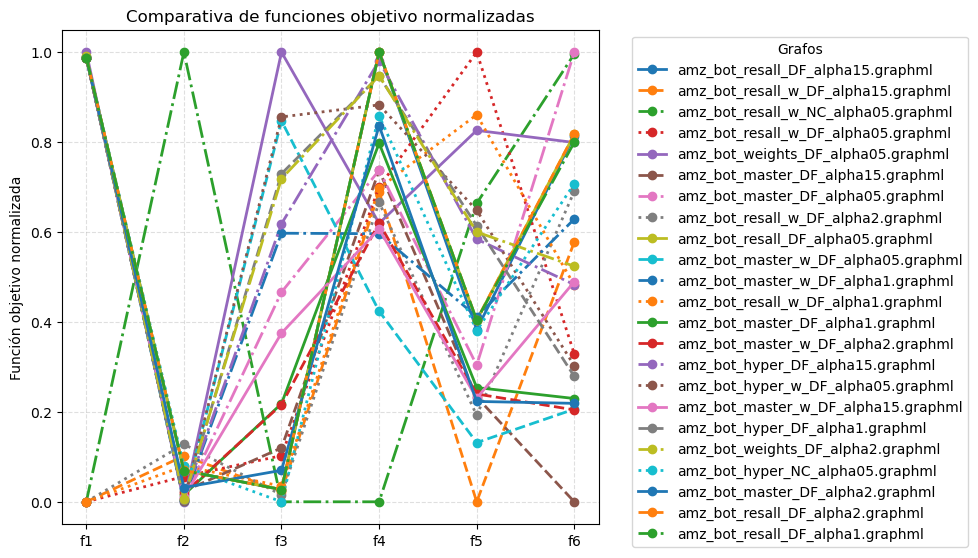

In [70]:
# Número máximo de grafos a graficar
N = len(pareto_sorted)
labels = [f"f{i+1}" for i in range(6)]  # nombres de funciones f1..f6

# Extraer vectores f y nombres de archivo
F = np.array([s["f"] for s in pareto_sorted[:N]])
names = [s["filename"] for s in pareto_sorted[:N]]

# Normalizar funciones objetivo columna por columna
F_norm = (F - F.min(axis=0)) / (F.max(axis=0) - F.min(axis=0) + 1e-8)

# Preparar figura
plt.figure(figsize=(10, 6))

# Colores y estilos variados
colors = plt.cm.tab10.colors
linestyles = ['-', '--', '-.', ':'] * 3

for i in range(N):
    plt.plot(
        labels,
        F_norm[i],
        label=names[i],
        color=colors[i % len(colors)],
        linestyle=linestyles[i % len(linestyles)],
        linewidth=2,
        marker='o'
    )

plt.ylabel("Función objetivo normalizada")
plt.title("Comparativa de funciones objetivo normalizadas")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Grafos", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("test.png")
plt.show()


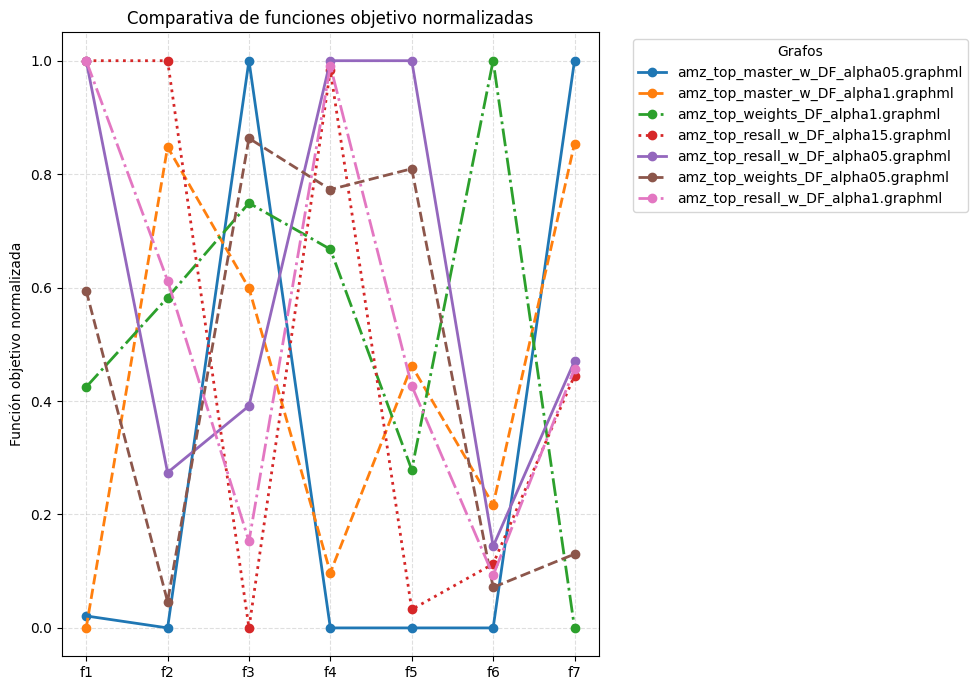

In [11]:
# Número máximo de grafos a graficar
N = len(pareto_sorted)
labels = [f"f{i+1}" for i in range(7)]  # nombres de funciones f1..f6

# Extraer vectores f y nombres de archivo
F = np.array([s["f"] for s in pareto_sorted[:N]])
names = [s["filename"] for s in pareto_sorted[:N]]

# Normalizar funciones objetivo columna por columna
F_norm = (F - F.min(axis=0)) / (F.max(axis=0) - F.min(axis=0) + 1e-8)

# Preparar figura
plt.figure(figsize=(10, 7))

# Colores y estilos variados
colors = plt.cm.tab10.colors
linestyles = ['-', '--', '-.', ':'] * 3

for i in range(N):
    plt.plot(
        labels,
        F_norm[i],
        label=names[i],
        color=colors[i % len(colors)],
        linestyle=linestyles[i % len(linestyles)],
        linewidth=2,
        marker='o'
    )

plt.ylabel("Función objetivo normalizada")
plt.title("Comparativa de funciones objetivo normalizadas")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Grafos", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("test.png")
plt.show()
